In [125]:
# Import stuff

import pandas as pd;
from sklearn.model_selection import train_test_split;
from sklearn import ensemble;
from sklearn.metrics import mean_absolute_error;
import joblib;
import sys;

sys.path.append("../Shared")

# noinspection PyUnresolvedReferences
import helpers;
print_line = helpers.print_line;
notebook_print = helpers.notebook_print;

In [126]:
# Load the dataset

dataset = pd.read_csv("../Datasets/ml_house_data_set_updated.csv");

# Remove fields we do not want to include in our model

del dataset["house_number"];
del dataset["unit_number"];
del dataset["street_name"];
del dataset["zip_code"];

sale_price = dataset["sale_price"];

# Remove the sale price from the feature data ( Because we are trying to predict it )
del dataset["sale_price"];

# Remove city so we don't have to one-hot encode it and end up with 60+ labels
del dataset["city"];

features = dataset;

# Replace categorical data such as "garage_type" and "city" with one-hot encoded data
# https://stackoverflow.com/questions/77643432/why-is-pd-get-dummies-returning-boolean-values-instead-of-the-binaries-of-0-1
features = pd.get_dummies(features, columns=["garage_type"], dtype=int);

print_line(features.columns);

notebook_print(features.head());

# Turn the data into numpy arrays

features = features.values;
sale_price = sale_price.values;

print(features);

Index(['year_built', 'stories', 'num_bedrooms', 'full_bathrooms',
       'half_bathrooms', 'livable_sqft', 'total_sqft', 'garage_sqft',
       'carport_sqft', 'has_fireplace', 'has_pool', 'has_central_heating',
       'has_central_cooling', 'garage_type_attached', 'garage_type_detached',
       'garage_type_none'],
      dtype='object')



,year_built,stories,num_bedrooms,full_bathrooms,half_bathrooms,livable_sqft,total_sqft,garage_sqft,carport_sqft,has_fireplace,has_pool,has_central_heating,has_central_cooling,garage_type_attached,garage_type_detached,garage_type_none
0,1978,1,4,1,1,1689,1859,508,0,True,False,True,True,1,0,0
1,1958,1,3,1,1,1984,2002,462,0,True,False,True,True,1,0,0
2,2002,1,3,2,0,1581,1578,0,625,False,False,True,True,0,0,1
3,2004,1,4,2,0,1829,2277,479,0,True,False,True,True,1,0,0
4,2006,1,4,2,0,1580,1749,430,0,True,False,True,True,1,0,0


[[1978 1 4 ... 1 0 0]
 [1958 1 3 ... 1 0 0]
 [2002 1 3 ... 0 0 1]
 ...
 [1983 1 1 ... 0 0 1]
 [1981 1 3 ... 1 0 0]
 [1980 1 3 ... 1 0 0]]


In [127]:
# Split the data into training and testing sets

RANDOM_STATE = 69;

features_train, features_test, sale_price_train, sale_price_test = train_test_split(
    features,
    sale_price,
    train_size=0.8,
    random_state=RANDOM_STATE
);

gradiant_boosting_regressor = ensemble.GradientBoostingRegressor(
    n_estimators=1000, # Number of decision trees to build
    learning_rate=0.1, # How much each additional decision tree influences the final prediction
    max_depth=5, # How deep each decision tree can be
    min_samples_leaf=6, # Minimum number of samples required to be at a leaf node
    max_features=0.1, # Percentage of features to consider when looking for the best split
    loss="huber", # How to calculate the model's error
    random_state=RANDOM_STATE
);

gradiant_boosting_regressor.fit(features_train, sale_price_train);

In [128]:
# Export the trained model in pickle format
print_line("Exporting model...");

OUTPUT_DIRECTORY = "../Outputs";

MODEL_FILE_NAME = "gradient_boosting_regressor";

PICKLE_OUTPUT_PATH = f"{OUTPUT_DIRECTORY}/{MODEL_FILE_NAME}.pkl";
ONNX_OUTPUT_PATH = f"{OUTPUT_DIRECTORY}/{MODEL_FILE_NAME}.onnx";


joblib.dump(gradiant_boosting_regressor, PICKLE_OUTPUT_PATH);

print_line(f"Model saved to {PICKLE_OUTPUT_PATH}");

Exporting model...

Model saved to ../Outputs/gradient_boosting_regressor.pkl



In [129]:
# Export the trained model in ONNX format
# See: https://onnx.ai/sklearn-onnx/

from skl2onnx import to_onnx;
import numpy as np;

# Convert the first row of the training data to a float32 numpy array
features_test_onnx_input = features_train[0:1].astype(np.float32);

print_line(features_test_onnx_input);

onnx_model = to_onnx(
    model=gradiant_boosting_regressor,
    X=features_test_onnx_input,
    name="gradient_boosting_regressor"
);

onnx_graph = onnx_model.graph;
input_graph = onnx_graph.input;
output_graph = onnx_graph.output;

first_input_node = input_graph[0];
first_output_node = output_graph[0];

# https://imgur.com/a/0riFX4S
first_input_node.type.tensor_type.shape.dim[0].dim_param = "batch_size";
first_output_node.type.tensor_type.shape.dim[0].dim_param = "batch_size";

with open(ONNX_OUTPUT_PATH, "wb") as file_stream:
    file_stream.write(onnx_model.SerializeToString())

print_line(f"Model saved to {ONNX_OUTPUT_PATH}");

[[1.992e+03 1.000e+00 3.000e+00 1.000e+00 1.000e+00 1.340e+03 1.345e+03
  4.020e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  0.000e+00 0.000e+00]]

Model saved to ../Outputs/gradient_boosting_regressor.onnx



In [130]:
# Verify the ONNX model against the actual model using the entire test set

import onnxruntime as rt;

onnx_session = rt.InferenceSession(ONNX_OUTPUT_PATH);

onnx_input_name = onnx_session.get_inputs()[0].name;
onnx_output_name = onnx_session.get_outputs()[0].name;

features_test_onnx_input = {onnx_input_name: features_test.astype(np.float32)};

predicted_sales_prices_onnx = onnx_session.run(None, features_test_onnx_input)[0].flatten();
predicted_sales_prices_actual = gradiant_boosting_regressor.predict(features_test);

print_line(predicted_sales_prices_onnx);
print(predicted_sales_prices_actual);

TOLERANCE = 0.001;

# Ensure the outputs are the same
assert np.allclose(
    predicted_sales_prices_onnx, predicted_sales_prices_actual,
    rtol=TOLERANCE,
    atol=TOLERANCE
);

[566000.2  174620.83 678686.4  ... 327964.28 586015.4  262265.75]

[566000.25545769 174621.00732646 678686.42226962 ... 327964.29041754
 586015.41018759 262265.77130506]


In [131]:
# Evaluate the model

print_line("Evaluating the model...");

mean_absolute_error_result = mean_absolute_error(sale_price_test, predicted_sales_prices_actual);
print_line(f"Mean absolute error: {mean_absolute_error_result}");

mean_absolute_error_result = mean_absolute_error(sale_price_test, predicted_sales_prices_onnx);
print_line(f"Mean absolute error ( ONNX ): {mean_absolute_error_result}");

Evaluating the model...

Mean absolute error: 96695.63779626427

Mean absolute error ( ONNX ): 96695.63485503747



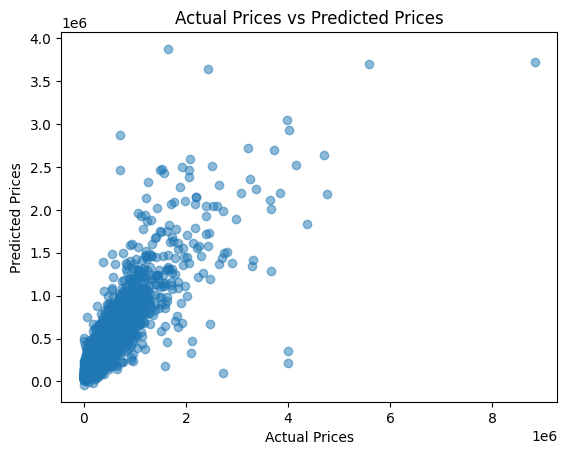

In [132]:
# Plot the results

import matplotlib.pyplot as plt;

plt.scatter(sale_price_test, predicted_sales_prices_actual, alpha=0.5);
plt.xlabel("Actual Prices");
plt.ylabel("Predicted Prices");
plt.title("Actual Prices vs Predicted Prices");